In [1]:
import numpy as np
import rasterio
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Load the TIF imagery and binary mask
with rasterio.open('/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/30_bands_final.tif') as src:
    imagery = src.read(1).astype(np.float32)

with rasterio.open('/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/Mask.tif') as src:
    mask = src.read(1).astype(np.uint8)

# Create a valid mask excluding NaN values
valid_mask = ~np.isnan(imagery)

# Flatten the imagery and mask arrays to 1D
X = imagery[valid_mask].reshape(-1, 1)
y = mask[valid_mask].reshape(-1)

# Define class names and their corresponding indices
class_names = ['non-peat', 'peat']
class_indices = [0, 1]

# Keep only the valid classes '0' (non-peat) and '1' (peat)
valid_classes_mask = np.isin(y, class_indices)
X = X[valid_classes_mask]
y = y[valid_classes_mask]



In [10]:
print(np.unique(y))

[0 1]


In [11]:
print(np.unique(y_train))

[0 1]


In [12]:
print(np.unique(y_test))

[0 1]


In [2]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:


# Perform grid search to find the best hyperparameters for the Random Forest model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best Random Forest model from grid search
best_rf_model = grid_search.best_estimator_

# Save the best Random Forest model as .sav file
joblib.dump(best_rf_model, '/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/Grid_search_rf_model.sav')



['/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/Grid_search_rf_model.sav']

In [1]:
import numpy as np
import rasterio
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Load the TIF imagery and binary mask
with rasterio.open('/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/Peatland_Ammeland_May2022_v2_30Band_30Jul2023.tif') as src:
    imagery = src.read(1).astype(np.float32)
    
# Create a valid mask excluding NaN values
valid_mask = ~np.isnan(imagery)
# Flatten the imagery and mask arrays to 1D
X = imagery[valid_mask].reshape(-1, 1)

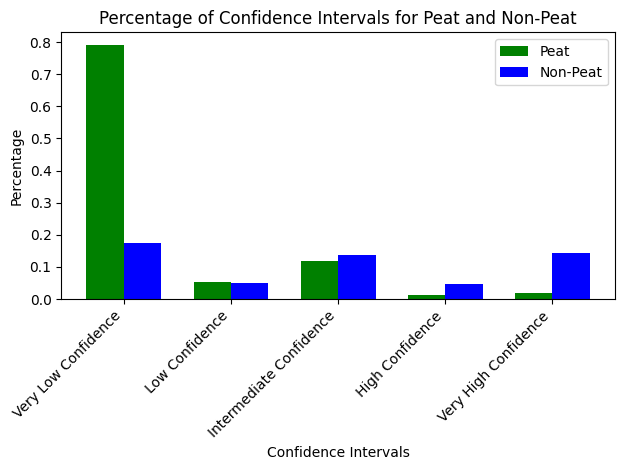

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Load the model from the .sav file
best_rf_model = joblib.load('/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/Grid_search_rf_model.sav')

# Calculate prediction probabilities for each class
prediction_probabilities = best_rf_model.predict_proba(X)

# Categorize probabilities into confidence intervals
conf_intervals = [0, 0.45, 0.60, 0.90, 0.95, 1.0]
interval_labels = ['Very Low Confidence', 'Low Confidence', 'Intermediate Confidence', 'High Confidence', 'Very High Confidence']

# Create empty arrays for each confidence interval
probabilities_peat_intervals = np.zeros_like(prediction_probabilities[:, 1], dtype=np.uint8)
probabilities_no_peat_intervals = np.zeros_like(prediction_probabilities[:, 0], dtype=np.uint8)

# Categorize probabilities for peat class
for i in range(len(conf_intervals) - 1):
    mask = (conf_intervals[i] <= prediction_probabilities[:, 1]) & (prediction_probabilities[:, 1] < conf_intervals[i + 1])
    probabilities_peat_intervals[mask] = i + 1

# Categorize probabilities for non-peat class
for i in range(len(conf_intervals) - 1):
    mask = (conf_intervals[i] <= prediction_probabilities[:, 0]) & (prediction_probabilities[:, 0] < conf_intervals[i + 1])
    probabilities_no_peat_intervals[mask] = i + 1

# Calculate percentages for each confidence interval
percentages_peat = [np.sum(probabilities_peat_intervals == i) / len(probabilities_peat_intervals) for i in range(1, len(interval_labels) + 1)]
percentages_no_peat = [np.sum(probabilities_no_peat_intervals == i) / len(probabilities_no_peat_intervals) for i in range(1, len(interval_labels) + 1)]

# Plot the bar graph
bar_width = 0.35
index = np.arange(len(interval_labels))

plt.bar(index, percentages_peat, bar_width, label='Peat', color='green')
plt.bar(index + bar_width, percentages_no_peat, bar_width, label='Non-Peat', color='blue')

plt.xlabel('Confidence Intervals')
plt.ylabel('Percentage')
plt.title('Percentage of Confidence Intervals for Peat and Non-Peat')
plt.xticks(index + bar_width / 2, interval_labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()



In [1]:
import numpy as np
import rasterio
import joblib
import matplotlib.pyplot as plt

# Load the TIF imagery and binary mask
with rasterio.open('/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/Peatland_Ammeland_May2022_v2_30Band_30Jul2023.tif') as src:
    imagery = src.read(1).astype(np.float32)
    transform = src.transform
    profile = src.profile

# Create a valid mask excluding NaN values
valid_mask = ~np.isnan(imagery)
# Flatten the imagery and mask arrays to 1D
X = imagery[valid_mask].reshape(-1, 1)

# Load the model from the .sav file
best_rf_model = joblib.load('/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/Grid_search_rf_model.sav')

# Calculate prediction probabilities for each class
prediction_probabilities = best_rf_model.predict_proba(X)

# Reshape the prediction probabilities to match the original imagery shape
prob_peat_map = np.full_like(imagery, np.nan, dtype=np.float32)
prob_no_peat_map = np.full_like(imagery, np.nan, dtype=np.float32)
prob_peat_map[valid_mask] = prediction_probabilities[:, 1]
prob_no_peat_map[valid_mask] = prediction_probabilities[:, 0]

# Create single classified TIF image for peat and non-peat
classified_map = np.zeros_like(imagery, dtype=np.uint8)
classified_map[prob_peat_map >= 0.60] = 1  # Assuming 0.60 as the threshold for peat classification

# Save the classified map as a TIF file
output_path = '/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/classified_Ammeland_map.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(classified_map, 1)

# Save the peat and non-peat probability maps as TIF files
output_peat_path = '/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/peat_probability_Ammeland_map.tif'
with rasterio.open(output_peat_path, 'w', **profile) as dst:
    dst.write(prob_peat_map, 1)

output_no_peat_path = '/home/jovyan/Desktop/shivanshi thesis/Tushar/Internship/non_peat_probability_Ammeland_map.tif'
with rasterio.open(output_no_peat_path, 'w', **profile) as dst:
    dst.write(prob_no_peat_map, 1)

In [18]:
print(np.unique(percentages_peat))

[0.02549436 0.04531673 0.10790118 0.22204037 0.58639782]


In [4]:
# Calculate confusion matrix, precision, recall, F1 score, and accuracy
y_pred = best_rf_model.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
accuracy = accuracy_score(y_test, y_pred)

print('Confusion Matrix:')
print(confusion_mat)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')



Confusion Matrix:
[[458929 157412]
 [106662 178726]]
Precision: 0.7228893815497852
Recall: 0.7071470475054035
F1 Score: 0.712816049922865
Accuracy: 0.7071470475054035


In [15]:
print(np.unique(y_pred))

[0 1]
